In [1]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# DSM Step 2 - Data Wrangling

Need to load the data provided, get an understanding of what is in each file and prepare for EDA stage.

In [2]:
os.chdir("../data/raw")

In [3]:
os.listdir()

['Cust w Industry a Last Purchased.xlsx',
 'REPEATSALE Items Purchased Report 2015 2020 dept 700.XLS',
 'Revised Customer Ranking Report 2015-2020.xlsx',
 'Sales Report by Zip Code (2010-2020).pdf',
 'T Client County Opportunity 1.18.19.xlsx',
 'T Client County Opportunty Detail 2019.xlsx',
 'T Client County Ownership 1.18.19.xlsx',
 'T Client Product Mix 8.5.2020.pdf',
 'T Client Product Trend Data.xlsx']

## File 1: Cust w Industry 

This file contains the identifying information for each customer, save customer name has been replaced with an Account Number for privacy purposes.

In [4]:
customers = pd.read_excel('Cust w Industry a Last Purchased.xlsx', header=0)
print(customers.head())
# This file lists the last purchase of each customer, and the customer's "vertical"
print(customers[customers['Account Number']=='1OTTSD'])

  Industry/Vertical     Contact Owner Account Number    City State/Province  \
0    911 & Dispatch     Keith Johnson         1ALLCD     NaN            NaN   
1    911 & Dispatch  Jessica Spindler         1ALPCO  ALPENA             MI   
2    911 & Dispatch  Jessica Spindler         7BENCS  BEULAH             MI   
3    911 & Dispatch  Jessica Spindler         7CCECD     NaN            NaN   
4    911 & Dispatch     Tom Gillespie         4EDWFD     NaN            NaN   

   Postal/ZIP Last Purchased  
0         NaN     2020-05-18  
1  49707-2453     2020-02-13  
2       49617     2019-07-29  
3         NaN     2020-05-18  
4         NaN     2020-01-24  
    Industry/Vertical  Contact Owner Account Number City State/Province  \
545   Law Enforcement  Keith Johnson         1OTTSD  NaN            NaN   

    Postal/ZIP Last Purchased  
545        NaN     2020-05-08  


In [5]:
# Examine datatypes
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Industry/Vertical  805 non-null    object        
 1   Contact Owner      805 non-null    object        
 2   Account Number     805 non-null    object        
 3   City               206 non-null    object        
 4   State/Province     207 non-null    object        
 5   Postal/ZIP         206 non-null    object        
 6   Last Purchased     619 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 44.1+ KB


In [6]:
# How many of the Zip, City, State are missing?
print('% missing of Zip: {:.2f}'.format(customers['Postal/ZIP'].isnull().sum() / len(customers['Postal/ZIP'])))
print('% missing of City: {:.2f}'.format(customers['City'].isnull().sum() / len(customers['City'])))
print('% missing of State: {:.2f}'.format(customers['State/Province'].isnull().sum() / len(customers['State/Province'])))

% missing of Zip: 0.74
% missing of City: 0.74
% missing of State: 0.74


74% of Zip/City/State are missing. There isn't a way to systematically look this up in this data file since no customer names. Will drop unless can find something helpful elsewhere.

Note from review - the Customer Ranking includes Zip codes, which can be used.

From talking to Micah, they use county as their primary internal unit of geography. I'll grab the ZIP codes from the customer ranking data, then turn that into a county column. 

In [7]:
# Drop city/state - ZIP will be the value used for TR's purposes
customers.drop(['City','State/Province'], axis=1, inplace=True)

### Categorical Data
Three of the columns - contact owner, account number & industry/vertical - seem like they should be categorical.

In [8]:
# Categorical data - 1) Industry/Vertical

# Industry/Vertical - there are some misspellings and things to clean up
customers['Industry/Vertical'].unique()

array(['911 & Dispatch', 'Agriculture', 'Argiculture',
       'College & Universities', 'Colleges & Universities',
       'Colleges and Universities', 'Construction', 'Fire & EMS',
       'Government Services', 'Healthcare', 'Hopitality', 'Hospitality',
       'hospitality', 'K12 Education', 'Law Enforcement', 'Manufacturing',
       'Mining', 'Mining & Materials', 'Oil & Gas', 'Property Management',
       'Religious Institutions', 'Retail', 'Security', 'Service',
       'Services & Training', 'Telecommunications', 'Transportation',
       'Utilities', 'Warehousing'], dtype=object)

When it comes to unique categories I see:
* 911 & Dispatch
* Agriculture (argiculture)
* Colleges & Universities (college & universities, colleges and universities)
* Construction
* Fire & EMS
* Gov't Services
* Healthcare
* Hospitality (Hopitality, hospitality)
* K12 Education
* Law Enforcement
* Manufacturing
* Mining & Materials (mining)
* Oil & Gas
* Property Management
* Religious Institutions
* Retail
* Security
* Services & Training (service)
* Telecommunications
* Transportation
* Utilities
* Warehousing

22 unique categories

In [9]:
# Define a function to map misspelled ones
def map_verticals(item):
    lookup = {
        'Argiculture':'Agriculture',
        'College & Universities':'Colleges & Universities',
        'Colleges and Universities':'Colleges & Universities',
        'Hopitality':'Hospitality',
        'hospitality':'Hospitality',
        'Mining':'Mining & Materials',
        'Service':'Services & Training'
    }
    
    if item in lookup.keys():
        return lookup[item]
    else: 
        return item

In [10]:
# Apply function
customers['Industry/Vertical'] = customers['Industry/Vertical'].apply(map_verticals)
print(customers['Industry/Vertical'].unique())
print(len(customers['Industry/Vertical'].unique()))

['911 & Dispatch' 'Agriculture' 'Colleges & Universities' 'Construction'
 'Fire & EMS' 'Government Services' 'Healthcare' 'Hospitality'
 'K12 Education' 'Law Enforcement' 'Manufacturing' 'Mining & Materials'
 'Oil & Gas' 'Property Management' 'Religious Institutions' 'Retail'
 'Security' 'Services & Training' 'Telecommunications' 'Transportation'
 'Utilities' 'Warehousing']
22


In [11]:
# Change dtype to category
customers['Industry/Vertical'] = customers['Industry/Vertical'].astype('category')
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Industry/Vertical  805 non-null    category      
 1   Contact Owner      805 non-null    object        
 2   Account Number     805 non-null    object        
 3   Postal/ZIP         206 non-null    object        
 4   Last Purchased     619 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](1), object(3)
memory usage: 26.9+ KB


__Categorical Data 2:__ Contact Owners

In [12]:
# Contact Owners
customers['Contact Owner'].unique()

array(['Keith Johnson', 'Jessica Spindler', 'Tom Gillespie',
       'Patrick McBride', 'Pat McBride', 'Kelly Hoek', 'Skip Petrovich'],
      dtype=object)

In [13]:
# Change Patrick McBride to Pat McBride
customers['Contact Owner'].replace('Patrick McBride', 'Pat McBride', inplace=True)
customers['Contact Owner'] = customers['Contact Owner'].astype('category')
customers['Contact Owner'].value_counts()

Jessica Spindler    195
Pat McBride         134
Kelly Hoek          132
Keith Johnson       129
Tom Gillespie       124
Skip Petrovich       91
Name: Contact Owner, dtype: int64

__Categorical Data 3:__ Account Number.

This will also serve as the index/reference for each customer

In [14]:
customers['Account Number'] = customers['Account Number'].astype('category')

In [15]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Industry/Vertical  805 non-null    category      
 1   Contact Owner      805 non-null    category      
 2   Account Number     805 non-null    category      
 3   Postal/ZIP         206 non-null    object        
 4   Last Purchased     619 non-null    datetime64[ns]
dtypes: category(3), datetime64[ns](1), object(1)
memory usage: 63.1+ KB


In [16]:
customers.set_index(['Account Number'], drop=True, inplace=True)
customers.head()

,Industry/Vertical,Contact Owner,Postal/ZIP,Last Purchased
Account Number,,,,
1ALLCD,911 & Dispatch,Keith Johnson,NaN,2020-05-18
1ALPCO,911 & Dispatch,Jessica Spindler,49707-2453,2020-02-13
7BENCS,911 & Dispatch,Jessica Spindler,49617,2019-07-29
7CCECD,911 & Dispatch,Jessica Spindler,NaN,2020-05-18
4EDWFD,911 & Dispatch,Tom Gillespie,NaN,2020-01-24


__Last Purchased:__

This final column is missing some data, but let's look at it more closely.

In [17]:
customers['Last Purchased'].describe()

count                     619
unique                    253
top       2020-04-30 00:00:00
freq                       37
first     2012-01-26 00:00:00
last      2020-05-18 00:00:00
Name: Last Purchased, dtype: object

This goes back to 2012. The full sales data the provided me goes back to 2015, so if missing values here mean last sale was a while back, those rows likely would end up getting dropped anyway.

I'll leave this column alone for now, but check it against full sales data to see if I can determine if a blank entry here simply means last purchase was long ago.

In [18]:
# Final Check
customers.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 805 entries, 1ALLCD to 1INTWA
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Industry/Vertical  805 non-null    category      
 1   Contact Owner      805 non-null    category      
 2   Postal/ZIP         206 non-null    object        
 3   Last Purchased     619 non-null    datetime64[ns]
dtypes: category(2), datetime64[ns](1), object(1)
memory usage: 63.0+ KB


## File 2: REPEATSALE Items Purchased 2015-2020

This is a list of all the sales of communications equipment from 2015 to 2020.

In [19]:
sales = pd.read_excel('REPEATSALE Items Purchased Report 2015 2020 dept 700.XLS', header=0)
sales.head()

,CUSTOMER #,ORDER TYPE,ORDER #,INVOICE DATE,QTY SHIPPED,ITEM #,DESCRIPTION,ITEM PRICE
0,1HOLPS,O,16588,05/08/15,1.0,T3000,MOTO MTR3000 BASE RADIO,6020.8
1,1EACCD,O,17800,12/31/15,2.0,ADP-U,"UNIVERSAL PIPE MOUNT 4-1/2""",519.0
2,1EACCD,O,17800,12/31/15,1.0,CONTINGENCY,CONTINGENCY,5000.0
3,1VANAI,O,17887,04/17/15,2.0,AAM27QNH9LA1,XPR 4550 403-470 1-25W 160 CH,681.0
4,1VANAI,O,17887,04/17/15,2.0,SEC1223MOTOTRBO,SAMLEX BASE STATION PWR SUPPLY,156.0


In [20]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418 entries, 0 to 11417
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CUSTOMER #    11418 non-null  object 
 1   ORDER TYPE    11418 non-null  object 
 2   ORDER #       11418 non-null  int64  
 3   INVOICE DATE  11418 non-null  object 
 4   QTY SHIPPED   11418 non-null  float64
 5   ITEM #        11418 non-null  object 
 6   DESCRIPTION   11399 non-null  object 
 7   ITEM PRICE    11418 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 713.8+ KB


__Initial Thoughts:__
There are some data types to fix first off. 
Only one column is missing data here - description. That column should tie to Item #, so we likely could drop it anyway. I'll double check that first.

The first thing that stands out though is the order type column.

In [21]:
# Check order type
sales['ORDER TYPE'].value_counts()

O    11418
Name: ORDER TYPE, dtype: int64

In [22]:
# All Order Types are the same, so can drop that column
sales.drop('ORDER TYPE', axis=1, inplace=True)
sales.head()

,CUSTOMER #,ORDER #,INVOICE DATE,QTY SHIPPED,ITEM #,DESCRIPTION,ITEM PRICE
0,1HOLPS,16588,05/08/15,1.0,T3000,MOTO MTR3000 BASE RADIO,6020.8
1,1EACCD,17800,12/31/15,2.0,ADP-U,"UNIVERSAL PIPE MOUNT 4-1/2""",519.0
2,1EACCD,17800,12/31/15,1.0,CONTINGENCY,CONTINGENCY,5000.0
3,1VANAI,17887,04/17/15,2.0,AAM27QNH9LA1,XPR 4550 403-470 1-25W 160 CH,681.0
4,1VANAI,17887,04/17/15,2.0,SEC1223MOTOTRBO,SAMLEX BASE STATION PWR SUPPLY,156.0


__Other notes on columns:__
* Customer # - should match up with Account Numbers, make categorical
* Order # - should serve as index for the sales dataframe
* Invoice Date - should be a datetime dtype
* Qty Shipped - if all whole quantities, could use int rather than float
* Item/Description - these provide the same information. item column is complete, so will keep that. Will create a function/dict to return the description of a given item # though.
* Item Price - leave as float

__Order Number__

In [23]:
sales.set_index(['ORDER #'], drop=True, inplace=True)
sales.head()

,CUSTOMER #,INVOICE DATE,QTY SHIPPED,ITEM #,DESCRIPTION,ITEM PRICE
ORDER #,,,,,,
16588,1HOLPS,05/08/15,1.0,T3000,MOTO MTR3000 BASE RADIO,6020.8
17800,1EACCD,12/31/15,2.0,ADP-U,"UNIVERSAL PIPE MOUNT 4-1/2""",519.0
17800,1EACCD,12/31/15,1.0,CONTINGENCY,CONTINGENCY,5000.0
17887,1VANAI,04/17/15,2.0,AAM27QNH9LA1,XPR 4550 403-470 1-25W 160 CH,681.0
17887,1VANAI,04/17/15,2.0,SEC1223MOTOTRBO,SAMLEX BASE STATION PWR SUPPLY,156.0


__Customer Number__

In [24]:
# Confirm that Customer # from sales data match up with Account Number from customer data
sales_list = list(sales['CUSTOMER #'].unique())
customer_list = list(customers.index)
print(len(sales_list), len(customer_list))

634 805


Lengths are different. It appears there are 171 customers that are in the customer list (i.e. have a customer record) but NOT in the sales list (i.e. haven't made a purchase in the 2015 to 2020 window).

In [25]:
# Create a list of the customer Accounts that don't show up on the sales reports
differences1 = np.setdiff1d(customer_list, sales_list, assume_unique=True)
len(differences1)

338

So actually it appears there are 338 customers that don't appear in the sales data. There's likely some of the sales reports that aren't in the customer data.

In [26]:
# Create a list of the accounts that ARE in the sales list but not the customer
differences2 = np.setdiff1d(sales_list, customer_list, assume_unique=True)
len(differences2)

167

It looks like there were a total of 467 customers (out of the original 805) that did NOT make a purchase of the items included in the sales data.

In [27]:
# Create list of Account Numbers that had last sale prior to 2015
no_sale_post2015 = customers[customers['Last Purchased'] < '2015']
len(no_sale_post2015)

29

Hm, so there were only 29 on that customer list that had a last sale prior to 2015. The rest must not be showing up in the sales data for another reason.

Ultimately I'll likely end up merging the sales/customer data so any irrelevant account numbers won't factor in. But want to make sure there isn't data I'm missing or that could help illuminate this so we could incude more data overall.

In [28]:
# Change to categorical
sales['CUSTOMER #'] = sales['CUSTOMER #'].astype('category')

__Invoice Date__

In [29]:
sales['INVOICE DATE'] = pd.to_datetime(sales['INVOICE DATE'])

__Quantity Shipped__

Will int work here?

In [30]:
check = []

for x in sales['QTY SHIPPED'].unique():
    check.append(x.is_integer())
    
print(sum(check))

94


So there are 3 non-integer values in the quantity shipped column. Will leave as floats.

__Item # / Description__

These represent the same information, so only need to keep one. Will keep the item # for modeling purposes but will leave the Description in for my own information to make EDA on the items/sales easiser for me to understand.

In [32]:
### Not using this code at this stage, but this is what I'll do come modelling time to drop the column

# Storing the descriptions for future use 
#descriptions = sales['DESCRIPTION'].values

# Dropping from df
#sales.drop('DESCRIPTION', axis=1, inplace=True)

In [31]:
print(sales.head())
print(sales.info())

        CUSTOMER # INVOICE DATE  QTY SHIPPED           ITEM #  \
ORDER #                                                         
16588       1HOLPS   2015-05-08          1.0            T3000   
17800       1EACCD   2015-12-31          2.0            ADP-U   
17800       1EACCD   2015-12-31          1.0      CONTINGENCY   
17887       1VANAI   2015-04-17          2.0     AAM27QNH9LA1   
17887       1VANAI   2015-04-17          2.0  SEC1223MOTOTRBO   

                            DESCRIPTION  ITEM PRICE  
ORDER #                                              
16588           MOTO MTR3000 BASE RADIO      6020.8  
17800       UNIVERSAL PIPE MOUNT 4-1/2"       519.0  
17800                       CONTINGENCY      5000.0  
17887     XPR 4550 403-470 1-25W 160 CH       681.0  
17887    SAMLEX BASE STATION PWR SUPPLY       156.0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11418 entries, 16588 to 48966
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
--- 

In [32]:
sales.to_csv('..\interim\sales.csv')

## File 3: Revised Customer Ranking Report 2015-2020

This looks like a ranking of total sales by customer including their initial sale date. 

Could use this to create things like length of time as a customer.

In [33]:
customer_totals = pd.read_excel('Revised Customer Ranking Report 2015-2020.xlsx', header=1)
customer_totals.head()
# This file lists lifetime sales by customer, along with that customer's "start date" aka initial
# sale.

,Rank,Customer,Amount,Address 2,Address 3,Open Date
0,1,1MIPMA,2791114.69,IL,,11/01/1999
1,2,1MOTMS,1544416.02,***DO NOT/SEND TO MOTOROLA***,MI,2/15/2002
2,3,1FOURW,1123935.02,11111 WILSON ROAD,NEW BUFFALO MI 49117,1/29/2008
3,4,7CCECD,1011834.96,PETOSKEY MI 49770,,11/01/1999
4,5,1OTTSD,848407.03,WEST OLIVE MI 49460,,11/01/1999


In [34]:
customer_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rank       1070 non-null   int64  
 1   Customer   1070 non-null   object 
 2   Amount     1070 non-null   float64
 3   Address 2  1070 non-null   object 
 4   Address 3  1070 non-null   object 
 5   Open Date  1070 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 50.3+ KB


This list of customers contains 1070, compared to the 805 in the original list of customers. 

In [35]:
# How many of these customers are missing addresses?
print(customer_totals['Address 2'].value_counts())
print(customer_totals['Address 2'].isnull().sum() / len(customer_totals['Address 2']))

HOLLAND MI 49423              37
HOLLAND MI 49424              22
GRAND RAPIDS MI 49503         21
ZEELAND MI 49464              16
CADILLAC MI 49601             14
                              ..
2608 Government Center Dr      1
4111 W 4 MILE ROAD             1
WAYLAND MI 49348-1208          1
4525 STAUFFER AVE              1
GRAND RAPIDS MI 49506-1801     1
Name: Address 2, Length: 651, dtype: int64
0.0


None are missing addresses! Sweet! Can use that information to populate the Zip at least.

__Plan for this set of data:__

This data will help add more information to the existing customers dataframe. Will keep:
* Customer rank
* Lifetime sales
* Start date

Also will pull Zip codes from the addresses and use that to make a "county" column.

In [36]:
customers.head()

,Industry/Vertical,Contact Owner,Postal/ZIP,Last Purchased
Account Number,,,,
1ALLCD,911 & Dispatch,Keith Johnson,NaN,2020-05-18
1ALPCO,911 & Dispatch,Jessica Spindler,49707-2453,2020-02-13
7BENCS,911 & Dispatch,Jessica Spindler,49617,2019-07-29
7CCECD,911 & Dispatch,Jessica Spindler,NaN,2020-05-18
4EDWFD,911 & Dispatch,Tom Gillespie,NaN,2020-01-24


In [37]:
# Merge 3 columns to keep into customers dataframe
combined = customers.merge(customer_totals, how='left', left_on='Account Number',
                           right_on='Customer')

combined.head()

,Industry/Vertical,Contact Owner,Postal/ZIP,Last Purchased,Rank,Customer,Amount,Address 2,Address 3,Open Date
0,911 & Dispatch,Keith Johnson,NaN,2020-05-18,9.0,1ALLCD,434459.15,ALLEGAN MI 49010,,11/01/1999
1,911 & Dispatch,Jessica Spindler,49707-2453,2020-02-13,74.0,1ALPCO,69214.06,STE 2,ALPENA MI 49707-2453,9/06/2013
2,911 & Dispatch,Jessica Spindler,49617,2019-07-29,440.0,7BENCS,6049.34,505 S. MICHIGAN AVE.,BEULAH MI 49617,11/01/1999
3,911 & Dispatch,Jessica Spindler,NaN,2020-05-18,4.0,7CCECD,1011834.96,PETOSKEY MI 49770,,11/01/1999
4,911 & Dispatch,Tom Gillespie,NaN,2020-01-24,162.0,4EDWFD,27984.04,EDWARDSBURG MI 49112,,11/01/1999


In [38]:
print(len(combined))

805


Perfect, so we ended up with just the 805 customers from our original customer dataframe. Now to clean up this information.

In [39]:
combined.set_index('Customer', inplace=True)

In [40]:
combined.sort_values('Rank', inplace=True)
combined.head()

,Industry/Vertical,Contact Owner,Postal/ZIP,Last Purchased,Rank,Amount,Address 2,Address 3,Open Date
Customer,,,,,,,,,
1FOURW,Hospitality,Tom Gillespie,49117,2020-05-18,3.0,1123935.02,11111 WILSON ROAD,NEW BUFFALO MI 49117,1/29/2008
7CCECD,911 & Dispatch,Jessica Spindler,NaN,2020-05-18,4.0,1011834.96,PETOSKEY MI 49770,,11/01/1999
1OTTSD,Law Enforcement,Keith Johnson,NaN,2020-05-08,5.0,848407.03,WEST OLIVE MI 49460,,11/01/1999
1KENCD,911 & Dispatch,Keith Johnson,NaN,2019-06-28,6.0,592820.26,PO BOX 905,WYOMING MI 49509,6/12/2017
4BERSH,Government Services,Tom Gillespie,NaN,2020-05-15,7.0,563431.43,701 MAIN STREET,ST. JOSEPH MI 49085-1392,11/01/1999


__How to get the Zip codes cleaned up?__

Combine both address columns. 
Create a function that strips all but the last 5 digits, unless the 5th from last is a dash, then it keeps the next 5 prior to those.

Let's try that

In [41]:
combined['Address'] = combined['Address 2'] + combined['Address 3']

In [42]:
combined.drop(['Address 2','Address 3'], axis=1, inplace=True)

In [43]:
combined.head()

,Industry/Vertical,Contact Owner,Postal/ZIP,Last Purchased,Rank,Amount,Open Date,Address
Customer,,,,,,,,
1FOURW,Hospitality,Tom Gillespie,49117,2020-05-18,3.0,1123935.02,1/29/2008,11111 WILSON ROADNEW BUFFALO MI 49117
7CCECD,911 & Dispatch,Jessica Spindler,NaN,2020-05-18,4.0,1011834.96,11/01/1999,PETOSKEY MI 49770
1OTTSD,Law Enforcement,Keith Johnson,NaN,2020-05-08,5.0,848407.03,11/01/1999,WEST OLIVE MI 49460
1KENCD,911 & Dispatch,Keith Johnson,NaN,2019-06-28,6.0,592820.26,6/12/2017,PO BOX 905WYOMING MI 49509
4BERSH,Government Services,Tom Gillespie,NaN,2020-05-15,7.0,563431.43,11/01/1999,701 MAIN STREETST. JOSEPH MI 49085-1392


In [44]:
# Create my zip-returning function

def get_zip(address):
    '''Takes a string address and returns the zip code'''
    address = str(address).strip()
    try:
        if address[-5]=='-':
            return address[-10:-5]
        else:
            return address[-5:]
    except:
        return

In [45]:
# Testing function
print(get_zip('701 MAIN STREETST. JOSEPH MI 49085-1392'))

print(get_zip('PO BOX 905WYOMING MI 49509'))

49085
49509


In [46]:
combined['Zip'] = combined['Address'].apply(get_zip)
combined.head()

,Industry/Vertical,Contact Owner,Postal/ZIP,Last Purchased,Rank,Amount,Open Date,Address,Zip
Customer,,,,,,,,,
1FOURW,Hospitality,Tom Gillespie,49117,2020-05-18,3.0,1123935.02,1/29/2008,11111 WILSON ROADNEW BUFFALO MI 49117,49117
7CCECD,911 & Dispatch,Jessica Spindler,NaN,2020-05-18,4.0,1011834.96,11/01/1999,PETOSKEY MI 49770,49770
1OTTSD,Law Enforcement,Keith Johnson,NaN,2020-05-08,5.0,848407.03,11/01/1999,WEST OLIVE MI 49460,49460
1KENCD,911 & Dispatch,Keith Johnson,NaN,2019-06-28,6.0,592820.26,6/12/2017,PO BOX 905WYOMING MI 49509,49509
4BERSH,Government Services,Tom Gillespie,NaN,2020-05-15,7.0,563431.43,11/01/1999,701 MAIN STREETST. JOSEPH MI 49085-1392,49085


In [47]:
combined.drop(['Postal/ZIP','Address'], axis=1, inplace=True)

In [48]:
display(combined.head())
print(combined.info())

,Industry/Vertical,Contact Owner,Last Purchased,Rank,Amount,Open Date,Zip
Customer,,,,,,,
1FOURW,Hospitality,Tom Gillespie,2020-05-18,3.0,1123935.02,1/29/2008,49117
7CCECD,911 & Dispatch,Jessica Spindler,2020-05-18,4.0,1011834.96,11/01/1999,49770
1OTTSD,Law Enforcement,Keith Johnson,2020-05-08,5.0,848407.03,11/01/1999,49460
1KENCD,911 & Dispatch,Keith Johnson,2019-06-28,6.0,592820.26,6/12/2017,49509
4BERSH,Government Services,Tom Gillespie,2020-05-15,7.0,563431.43,11/01/1999,49085


<class 'pandas.core.frame.DataFrame'>
Index: 805 entries, 1FOURW to nan
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Industry/Vertical  805 non-null    category      
 1   Contact Owner      805 non-null    category      
 2   Last Purchased     619 non-null    datetime64[ns]
 3   Rank               648 non-null    float64       
 4   Amount             648 non-null    float64       
 5   Open Date          648 non-null    object        
 6   Zip                648 non-null    object        
dtypes: category(2), datetime64[ns](1), float64(2), object(2)
memory usage: 40.3+ KB
None


So actually there are only 648 customers with fully fleshed out information here.

__Zip Code to County__

I downloaded a csv file from https://www.unitedstateszipcodes.org/zip-code-database/ that contains a list of all the zip codes in the US.

Will use that to create a filter to take in a zip code and return the county.

In [50]:
# Create the zip/county mapping base
counties = pd.read_csv('..\external\zip_code_database.csv')
counties.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [51]:
counties = counties[counties['state']=='MI']
counties.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
20942,48001,STANDARD,0,Algonac,"Clay, Pearl Beach, Russell Is, Russell Island","Clay Township, Clay Twp",MI,St. Clair County,America/Detroit,810,NaN,US,42.61,-82.53,10610
20943,48002,STANDARD,0,Allenton,"Berlin, Berville","Berlin Township, Berlin Twp",MI,St. Clair County,America/Detroit,NaN,NaN,US,42.92,-82.88,3050
20944,48003,STANDARD,0,Almont,NaN,Almont Township,MI,Lapeer County,America/Detroit,810,NaN,US,42.92,-83.04,6120
20945,48004,PO BOX,0,Anchorville,NaN,NaN,MI,St. Clair County,America/Detroit,NaN,NaN,US,42.69,-82.69,142
20946,48005,STANDARD,0,Armada,NaN,Armada Township,MI,Macomb County,America/Detroit,586,NaN,US,42.84,-82.88,5040


In [52]:
county_filter = pd.Series(counties['county'].values, index=counties['zip'], name='county')

In [53]:
def county_lookup(zip):
    '''Take a zip code and returns the correspding MI county'''
    try:
        zip=int(zip)
        return county_filter.loc[zip][:-7]
    except:
        return np.nan

In [54]:
combined['County']=combined['Zip'].apply(county_lookup)

In [55]:
display(combined.head())
display(combined.County.value_counts())

,Industry/Vertical,Contact Owner,Last Purchased,Rank,Amount,Open Date,Zip,County
Customer,,,,,,,,
1FOURW,Hospitality,Tom Gillespie,2020-05-18,3.0,1123935.02,1/29/2008,49117,Berrien
7CCECD,911 & Dispatch,Jessica Spindler,2020-05-18,4.0,1011834.96,11/01/1999,49770,Emmet
1OTTSD,Law Enforcement,Keith Johnson,2020-05-08,5.0,848407.03,11/01/1999,49460,Ottawa
1KENCD,911 & Dispatch,Keith Johnson,2019-06-28,6.0,592820.26,6/12/2017,49509,Kent
4BERSH,Government Services,Tom Gillespie,2020-05-15,7.0,563431.43,11/01/1999,49085,Berrien


Ottawa            130
Kent              101
Berrien            48
Allegan            33
Grand Traverse     24
Muskegon           21
Emmet              19
Mason              19
Oceana             18
Wexford            18
Van Buren          16
Roscommon          13
St. Joseph         11
Cheboygan          10
Leelanau           10
Manistee            8
Newaygo             8
Charlevoix          8
Cass                7
Oakland             7
Crawford            6
Montmorency         6
Presque Isle        5
Missaukee           5
Kalkaska            5
Antrim              5
Alpena              5
Kalamazoo           4
Lake                3
Ionia               3
Otsego              3
Wayne               3
Montcalm            3
Benzie              3
Ingham              2
Saginaw             2
Ogemaw              2
Mackinac            2
Oscoda              1
Jackson             1
Eaton               1
Branch              1
Midland             1
Livingston          1
Huron               1
Mecosta   

In [56]:
# Final clean up of customers dataframe
customers = combined.drop('Zip', axis=1)
customers.columns = ['industry','contact_owner','last_purchase','rank','lifetime_sales',
                    'first_sale','county']
customers.index.rename('customer', inplace=True)
customers.head()

,industry,contact_owner,last_purchase,rank,lifetime_sales,first_sale,county
customer,,,,,,,
1FOURW,Hospitality,Tom Gillespie,2020-05-18,3.0,1123935.02,1/29/2008,Berrien
7CCECD,911 & Dispatch,Jessica Spindler,2020-05-18,4.0,1011834.96,11/01/1999,Emmet
1OTTSD,Law Enforcement,Keith Johnson,2020-05-08,5.0,848407.03,11/01/1999,Ottawa
1KENCD,911 & Dispatch,Keith Johnson,2019-06-28,6.0,592820.26,6/12/2017,Kent
4BERSH,Government Services,Tom Gillespie,2020-05-15,7.0,563431.43,11/01/1999,Berrien


## File 4: Sales Report by Zip Code"

This file is being set aside. It includes total sales by zip code from 2010 to 2020. The issues are:
* that timeframe doesn't match with the 2015 to 2020 timeframe of the rest of the data
* it is completely aggregated by zip with no way of breaking it out any further
* with a list of all the sales I can re-create this kind of "gouped by zip code" data easily, and ONLY for the time frame that matches the rest of the data

## Files 5 & 6: CT county Opp Detail 2019 & 1.18.19

These time-frames have very near overlap. Will use the 2019 file as that is the most recent. Will merge on county the following:
* population
* current motorola
* motorola market opp
* % to total market opp

In [57]:
county_opps = pd.read_excel('Tele-Rad County Opportunty Detail 2019.xlsx', usecols=[1,2,3,4,5,6])
county_opps.head()

,"County, State",POPULATION,CURRENT MOTOROLA $,MOTOROLA MARKET OPPORTUNITY,TOTAL MARKET OPPORTUNITY,% to TOTAL MARKET OPPORTUNITY
0,"KENT, MI",609544,910110,1601574,2162125,0.421
1,"OTTAWA, MI",267017,344342,825673,1114659,0.309
2,"KALAMAZOO, MI",252763,544949,1117141,1508141,0.361
3,"MUSKEGON, MI",171153,67069,281690,380282,0.176
4,"BERRIEN, MI",156290,200519,510290,688892,0.291


In [58]:
# Change the county, state column to match up with customers df
county_opps['County, State'].value_counts()

ROSCOMMON, MI         1
CHEBOYGAN, MI         1
NEWAYGO, MI           1
MISSAUKEE, MI         1
PRESQUE ISLE, MI      1
WEXFORD, MI           1
ALPENA, MI            1
MASON, MI             1
IONIA, MI             1
MANISTEE, MI          1
VAN BUREN, MI         1
KALAMAZOO, MI         1
OCEANA, MI            1
GRAND TRAVERSE, MI    1
ST JOSEPH, MI         1
MONTMORENCY, MI       1
BARRY, MI             1
OGEMAW, MI            1
LAKE, MI              1
OTTAWA, MI            1
BERRIEN, MI           1
EATON, MI             1
LEELANAU, MI          1
KALKASKA, MI          1
OTSEGO, MI            1
CRAWFORD, MI          1
KENT, MI              1
CASS, MI              1
MUSKEGON, MI          1
ALLEGAN, MI           1
BENZIE, MI            1
ANTRIM, MI            1
CHARLEVOIX, MI        1
EMMET, MI             1
Name: County, State, dtype: int64

In [59]:
def format_county(county):
    '''Takes the county, state name from opps dataframe and returns the county formatted to 
    match the customers dataframe.'''
    return county[:-4].lower()

In [60]:
format_county('MONTMORENCY, MI')

'montmorency'

In [61]:
county_opps['county']=county_opps['County, State'].apply(format_county)

In [62]:
county_opps.head()

,"County, State",POPULATION,CURRENT MOTOROLA $,MOTOROLA MARKET OPPORTUNITY,TOTAL MARKET OPPORTUNITY,% to TOTAL MARKET OPPORTUNITY,county
0,"KENT, MI",609544,910110,1601574,2162125,0.421,kent
1,"OTTAWA, MI",267017,344342,825673,1114659,0.309,ottawa
2,"KALAMAZOO, MI",252763,544949,1117141,1508141,0.361,kalamazoo
3,"MUSKEGON, MI",171153,67069,281690,380282,0.176,muskegon
4,"BERRIEN, MI",156290,200519,510290,688892,0.291,berrien


In [63]:
# Create a column in customers that will match format so we can merge
customers['county_merge'] = customers['county'].str.lower().replace('.','')

In [64]:
customers.head()

,industry,contact_owner,last_purchase,rank,lifetime_sales,first_sale,county,county_merge
customer,,,,,,,,
1FOURW,Hospitality,Tom Gillespie,2020-05-18,3.0,1123935.02,1/29/2008,Berrien,berrien
7CCECD,911 & Dispatch,Jessica Spindler,2020-05-18,4.0,1011834.96,11/01/1999,Emmet,emmet
1OTTSD,Law Enforcement,Keith Johnson,2020-05-08,5.0,848407.03,11/01/1999,Ottawa,ottawa
1KENCD,911 & Dispatch,Keith Johnson,2019-06-28,6.0,592820.26,6/12/2017,Kent,kent
4BERSH,Government Services,Tom Gillespie,2020-05-15,7.0,563431.43,11/01/1999,Berrien,berrien


In [65]:
customers = pd.merge(customers.reset_index(), county_opps, how='left', left_on='county_merge',
                    right_on='county')
customers.head()

,customer,industry,contact_owner,last_purchase,rank,lifetime_sales,first_sale,county_x,county_merge,"County, State",POPULATION,CURRENT MOTOROLA $,MOTOROLA MARKET OPPORTUNITY,TOTAL MARKET OPPORTUNITY,% to TOTAL MARKET OPPORTUNITY,county_y
0,1FOURW,Hospitality,Tom Gillespie,2020-05-18,3.0,1123935.02,1/29/2008,Berrien,berrien,"BERRIEN, MI",156290.0,200519.0,510290.0,688892.0,0.291,berrien
1,7CCECD,911 & Dispatch,Jessica Spindler,2020-05-18,4.0,1011834.96,11/01/1999,Emmet,emmet,"EMMET, MI",32858.0,14103.0,80040.0,108054.0,0.131,emmet
2,1OTTSD,Law Enforcement,Keith Johnson,2020-05-08,5.0,848407.03,11/01/1999,Ottawa,ottawa,"OTTAWA, MI",267017.0,344342.0,825673.0,1114659.0,0.309,ottawa
3,1KENCD,911 & Dispatch,Keith Johnson,2019-06-28,6.0,592820.26,6/12/2017,Kent,kent,"KENT, MI",609544.0,910110.0,1601574.0,2162125.0,0.421,kent
4,4BERSH,Government Services,Tom Gillespie,2020-05-15,7.0,563431.43,11/01/1999,Berrien,berrien,"BERRIEN, MI",156290.0,200519.0,510290.0,688892.0,0.291,berrien


In [66]:
customers.drop(['county_merge','County, State','county_y', 'TOTAL MARKET OPPORTUNITY'],
               axis=1, inplace=True)

In [67]:
customers.columns
customers.columns = ['customer', 'industry', 'contact_owner', 'last_purchase', 'rank', 
                     'lifetime_sales',
                     'first_sale', 'county', 'population', 'current_motorola',
                     'market_opportunity','%_market_opp']

In [68]:
customers.head()

,customer,industry,contact_owner,last_purchase,rank,lifetime_sales,first_sale,county,population,current_motorola,market_opportunity,%_market_opp
0,1FOURW,Hospitality,Tom Gillespie,2020-05-18,3.0,1123935.02,1/29/2008,Berrien,156290.0,200519.0,510290.0,0.291
1,7CCECD,911 & Dispatch,Jessica Spindler,2020-05-18,4.0,1011834.96,11/01/1999,Emmet,32858.0,14103.0,80040.0,0.131
2,1OTTSD,Law Enforcement,Keith Johnson,2020-05-08,5.0,848407.03,11/01/1999,Ottawa,267017.0,344342.0,825673.0,0.309
3,1KENCD,911 & Dispatch,Keith Johnson,2019-06-28,6.0,592820.26,6/12/2017,Kent,609544.0,910110.0,1601574.0,0.421
4,4BERSH,Government Services,Tom Gillespie,2020-05-15,7.0,563431.43,11/01/1999,Berrien,156290.0,200519.0,510290.0,0.291


In [69]:
customers.to_csv('..\interim\customers.csv')

## File 7: CT County Ownership

This data too narrow for our purposes. Will be ignored for this project.

## Files 8 & 9: CT Product Mix & Trend Data

These are for my background information. Give an understanding of the product "levels" for the items that will show up in the sales information.

# Create Final Dataset

In [70]:
merged = pd.merge(sales, customers, left_on='CUSTOMER #', right_on='customer', how='left')

In [71]:
merged.head()

,CUSTOMER #,INVOICE DATE,QTY SHIPPED,ITEM #,DESCRIPTION,ITEM PRICE,customer,industry,contact_owner,last_purchase,rank,lifetime_sales,first_sale,county,population,current_motorola,market_opportunity,%_market_opp
0,1HOLPS,2015-05-08,1.0,T3000,MOTO MTR3000 BASE RADIO,6020.8,1HOLPS,K12 Education,Keith Johnson,2020-03-06,129.0,39760.49,11/01/1999,Ottawa,267017.0,344342.0,825673.0,0.309
1,1EACCD,2015-12-31,2.0,ADP-U,"UNIVERSAL PIPE MOUNT 4-1/2""",519.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1EACCD,2015-12-31,1.0,CONTINGENCY,CONTINGENCY,5000.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1VANAI,2015-04-17,2.0,AAM27QNH9LA1,XPR 4550 403-470 1-25W 160 CH,681.0,1VANAI,Healthcare,Skip Petrovich,2020-04-19,172.0,25907.89,10/25/2004,Kent,609544.0,910110.0,1601574.0,0.421
4,1VANAI,2015-04-17,2.0,SEC1223MOTOTRBO,SAMLEX BASE STATION PWR SUPPLY,156.0,1VANAI,Healthcare,Skip Petrovich,2020-04-19,172.0,25907.89,10/25/2004,Kent,609544.0,910110.0,1601574.0,0.421


In [72]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11418 entries, 0 to 11417
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CUSTOMER #          11418 non-null  object        
 1   INVOICE DATE        11418 non-null  datetime64[ns]
 2   QTY SHIPPED         11418 non-null  float64       
 3   ITEM #              11418 non-null  object        
 4   DESCRIPTION         11399 non-null  object        
 5   ITEM PRICE          11418 non-null  float64       
 6   customer            9372 non-null   object        
 7   industry            9372 non-null   category      
 8   contact_owner       9372 non-null   category      
 9   last_purchase       9309 non-null   datetime64[ns]
 10  rank                9372 non-null   float64       
 11  lifetime_sales      9372 non-null   float64       
 12  first_sale          9372 non-null   object        
 13  county              8425 non-null   object    

In [73]:
final = merged[merged['population'].notna()]
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7890 entries, 0 to 11417
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   CUSTOMER #          7890 non-null   object        
 1   INVOICE DATE        7890 non-null   datetime64[ns]
 2   QTY SHIPPED         7890 non-null   float64       
 3   ITEM #              7890 non-null   object        
 4   DESCRIPTION         7878 non-null   object        
 5   ITEM PRICE          7890 non-null   float64       
 6   customer            7890 non-null   object        
 7   industry            7890 non-null   category      
 8   contact_owner       7890 non-null   category      
 9   last_purchase       7829 non-null   datetime64[ns]
 10  rank                7890 non-null   float64       
 11  lifetime_sales      7890 non-null   float64       
 12  first_sale          7890 non-null   object        
 13  county              7890 non-null   object     

In [74]:
final.columns

Index(['CUSTOMER #', 'INVOICE DATE', 'QTY SHIPPED', 'ITEM #', 'DESCRIPTION',
       'ITEM PRICE', 'customer', 'industry', 'contact_owner', 'last_purchase',
       'rank', 'lifetime_sales', 'first_sale', 'county', 'population',
       'current_motorola', 'market_opportunity', '%_market_opp'],
      dtype='object')

In [75]:
final.columns = ['customer', 'invoice_date', 'qty_shipped', 'item', 'description',
       'item_price', 'customer', 'industry', 'contact_owner', 'last_purchase',
       'rank', 'lifetime_sales', 'first_sale', 'county', 'population',
       'current_motorola', 'market_opportunity', '%_market_opp']

In [76]:
final.describe()

,qty_shipped,item_price,rank,lifetime_sales,population,current_motorola,market_opportunity,%_market_opp
count,7890.000000,7890.000000,7890.000000,7.890000e+03,7890.000000,7890.000000,7.890000e+03,7890.000000
mean,6.699683,740.812915,135.935234,1.797331e+05,204573.091381,263671.593029,5.758764e+05,0.283741
std,37.306177,5897.547907,159.214264,2.606313e+05,189557.289689,297295.369883,5.110980e+05,0.285525
min,0.000000,0.500000,3.000000,1.999000e+01,9598.000000,967.000000,5.375000e+03,0.015000
25%,1.000000,58.000000,26.000000,2.450856e+04,52212.000000,25212.000000,1.218750e+05,0.176000
50%,1.000000,150.000000,76.000000,6.796741e+04,156290.000000,200519.000000,5.102900e+05,0.291000
75%,4.000000,481.000000,184.000000,2.082524e+05,267017.000000,344342.000000,8.256730e+05,0.309000
max,1500.000000,404227.350000,1061.000000,1.123935e+06,609544.000000,910110.000000,1.601574e+06,4.437000


### Explore numeric columns

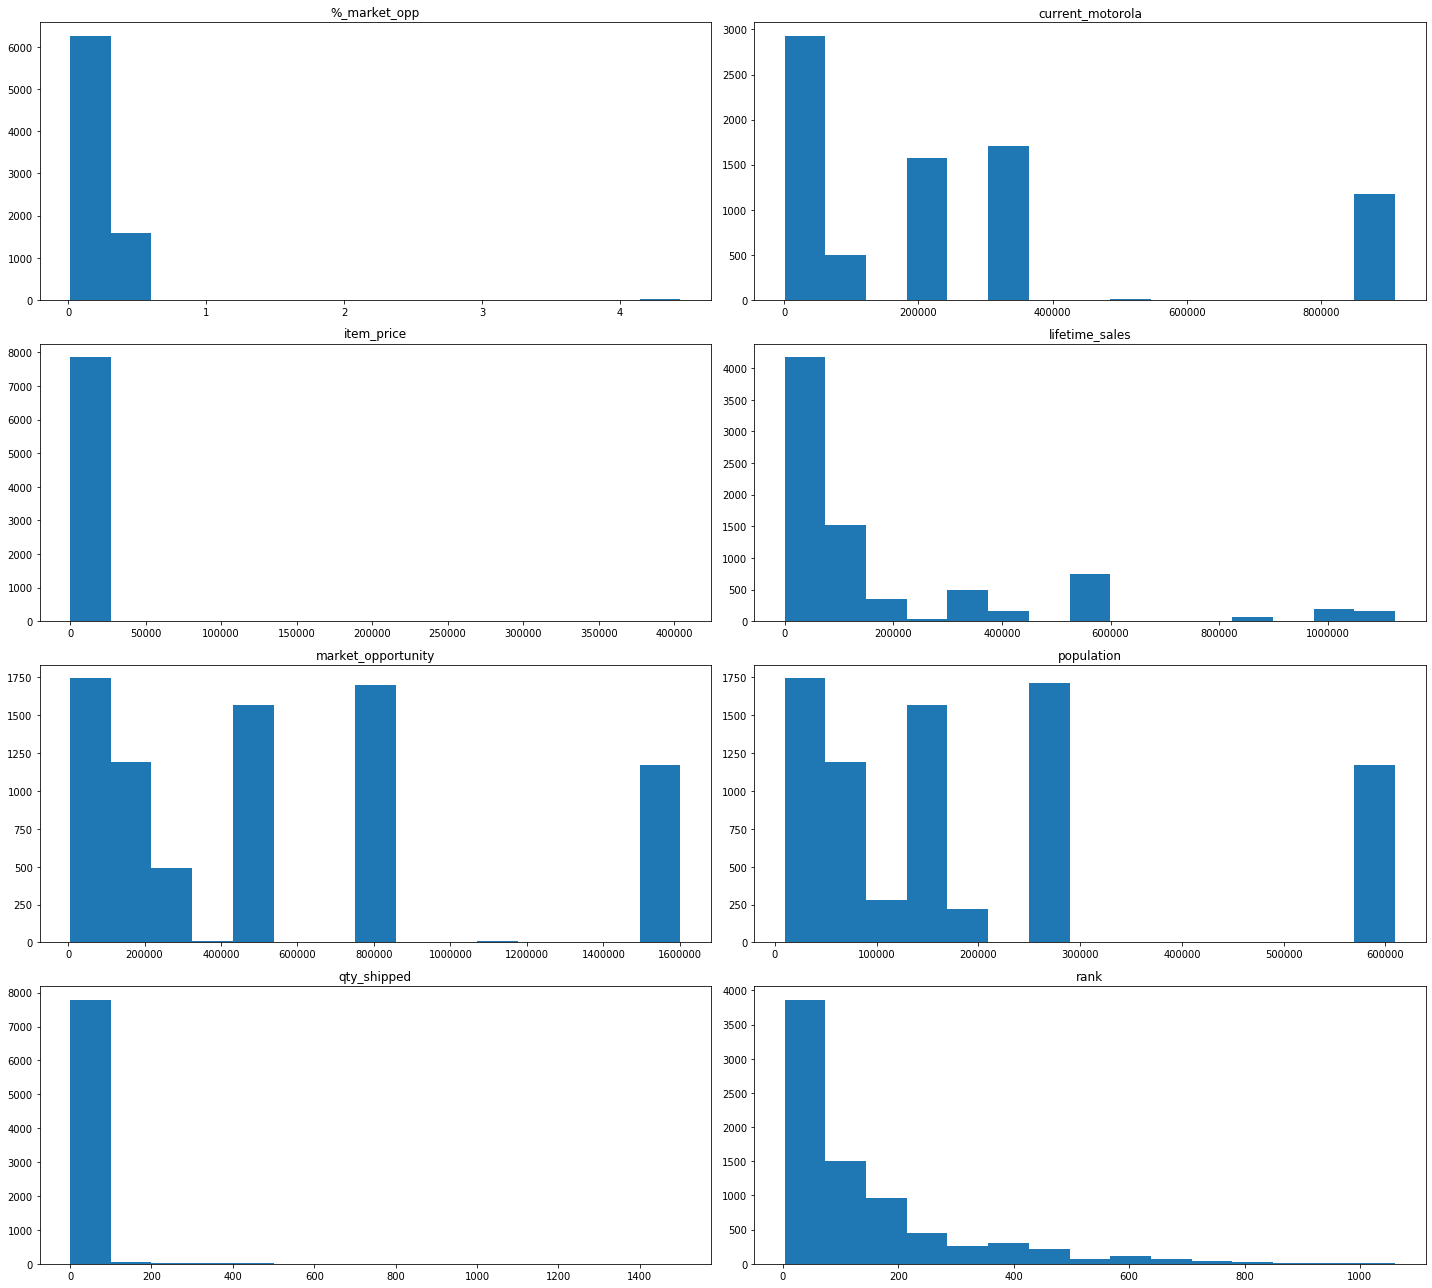

In [86]:
# Plot histograms of all numberic columns
final.hist(bins=15, layout=(4,2), figsize=(20,18), grid=False)
plt.tight_layout()

plt.savefig('../../figures/histograms.png')

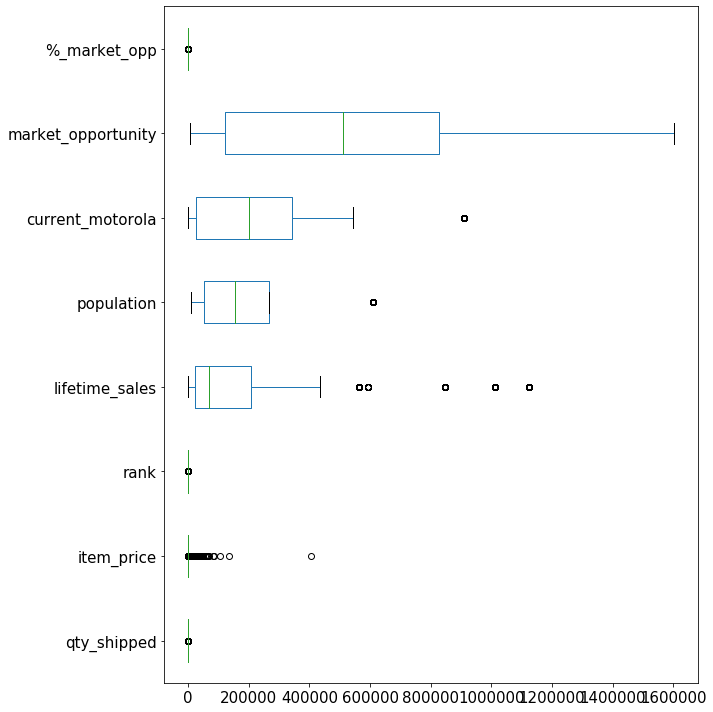

In [81]:
# Check for extreme outliers
final.boxplot(grid=False, vert=False, fontsize=15, figsize=(10,10))
plt.tight_layout()

plt.savefig('../../figures/boxplots.png')

### Outliers

There are several outliers. Which are meaningful?

* __Current Motorola:__ We have one value that is extremely high. Will investigate that further.
* __Population:__ There is one county with significantly higher population than the rest. That makes sense given the population distribution of Michigan.
* __Lifetime Sales:__ Again, here, this fits with the business having several very high-value customers that have a long track record of sales.
* __Item Price:__ Having an item with a 400k+ item price seems a bit extreme, but it is possible. We will examine the item prices in depth when creating our target feature.

So the only one I need to examine here is the Current Motorola one. 

In [83]:
final['%_market_opp'].max()

4.437

In [85]:
# Where are we finding the max value?
final[final['%_market_opp']==4.437].county.unique()

array(['Crawford'], dtype=object)

So clearly Crawford county is a bit skewed. Having a percentage of county sales at over 400% doesn't make much sense mathematically.

But upon further inspection it does fit: 

The "market opportunity" column is an estimate from Motorola of how much business is available within a given county. Obviously they can be wrong. In this case actual sales are way beyond what Motorola predicted existed in Crawford county.

### Interesting Plots

There are countless ways to chunk up this data, but a few that will be important towards our business goal are created below.

__Current Motorola opportunity by county__

Which counties have the biggest markets?

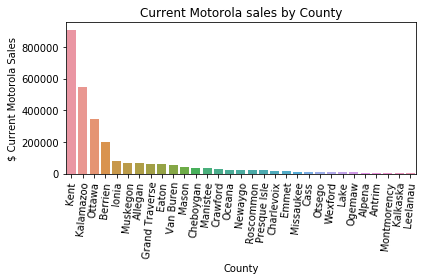

In [110]:
# Let's see how all of these vary by county

# Sort data by current_motorola descending
plot1 = final.groupby('county')['current_motorola'].max().nlargest(31)

sns.barplot(x=plot1.index,y=plot1.values)
plt.title('Current Motorola sales by County')
plt.xticks(rotation=85)
plt.xlabel('County')
plt.ylabel("$ Current Motorola Sales")
plt.tight_layout()

plt.savefig('../../figures/sales_by_county.png')

__Population by county__

Does this align with the total sales by county?

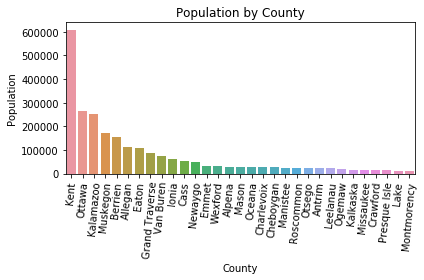

In [111]:
# Sort data by population descending
plot2 = final.groupby('county')['population'].max().nlargest(31)

sns.barplot(x=plot2.index,y=plot2.values)
plt.title('Population by County')
plt.xticks(rotation=85)
plt.xlabel('County')
plt.ylabel("Population")
plt.tight_layout()

plt.savefig('../../figures/population_by_county.png')

__Total Sales by Item__

In [116]:
sales_by_item = pd.DataFrame(final[['item', 'item_price', 'qty_shipped']])
sales_by_item['total_sale'] = sales_by_item.item_price * sales_by_item.qty_shipped

sales_by_item.head()

,item,item_price,qty_shipped,total_sale
0,T3000,6020.8,1.0,6020.8
3,AAM27QNH9LA1,681.0,2.0,1362.0
4,SEC1223MOTOTRBO,156.0,2.0,312.0
5,0180355A80,28.5,2.0,57.0
6,0180352A11,12.0,2.0,24.0


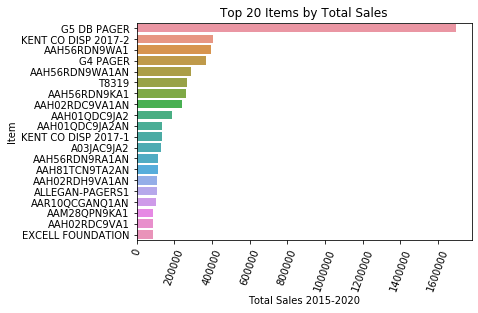

<Figure size 1440x1080 with 0 Axes>

In [121]:
plot3 = sales_by_item.groupby('item')['total_sale'].sum().nlargest(20)

sns.barplot(x=plot3.values,y=plot3.index)
plt.title('Top 20 Items by Total Sales')
plt.xlabel('Total Sales 2015-2020')
plt.xticks(rotation=70)
plt.ylabel("Item")
plt.figure(figsize=(20,15))
plt.tight_layout()

plt.savefig('../../figures/top20items.png')

### Correlations

Check for correlations between variables

In [123]:
num_cols = ['qty_shipped', 'item_price', 'rank', 'lifetime_sales',
            'population', 'current_motorola', 'market_opportunity', '%_market_opp']

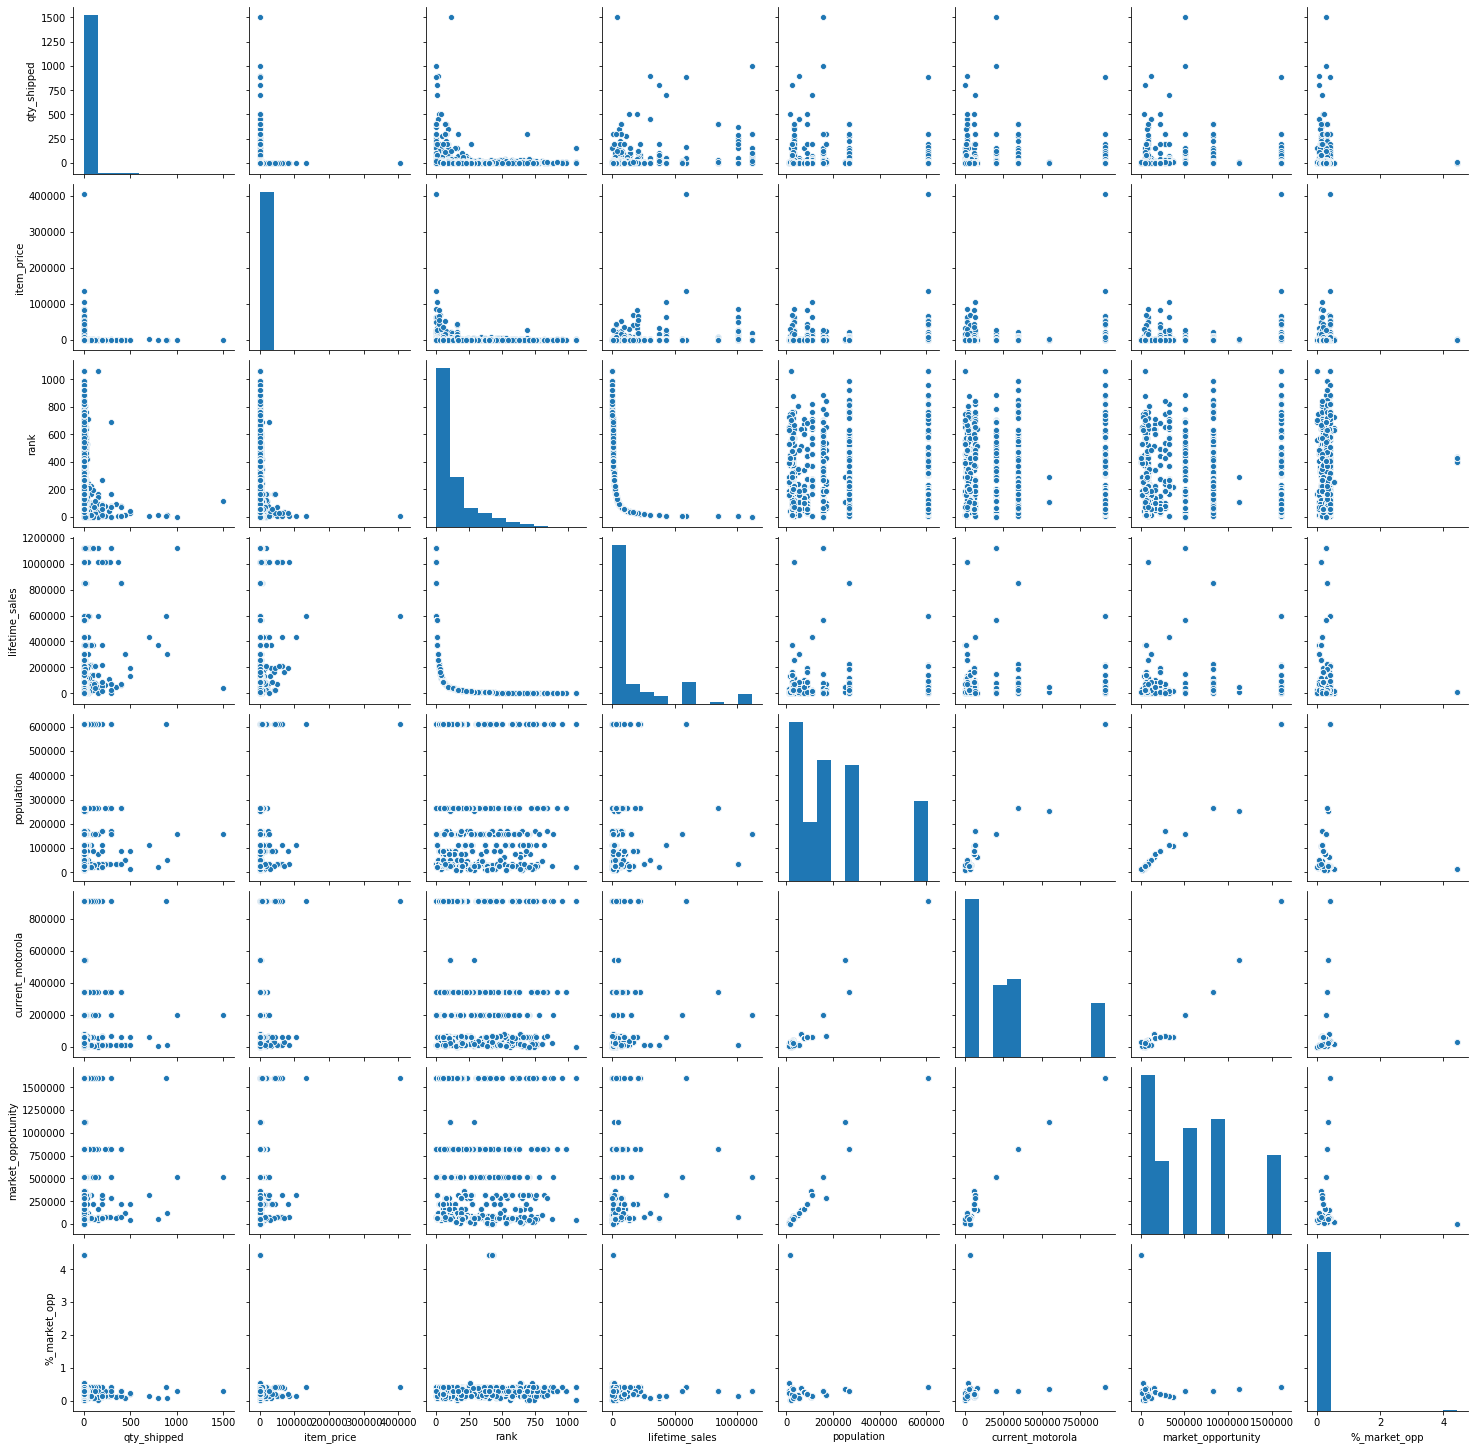

In [124]:
sns.pairplot(final[num_cols])

Lifetime sales and rank seem logrithmatically correlated. It makes sense that they would be correlated as they essentially give the same information.

I will drop rank.

Population, current motorola and market opportunity also all seem correlated. Again, this makes quite a bit of sense.

Will keep the market opportunity column. That, in combination with the %_market_opp column can give us all the information we should need

,qty_shipped,item_price,rank,lifetime_sales,population,current_motorola,market_opportunity,%_market_opp
qty_shipped,1.000000,-0.015118,-0.029325,0.066220,0.015590,0.014202,0.014069,-0.011150
item_price,-0.015118,1.000000,-0.039190,0.068976,0.019067,0.020526,0.014706,-0.002355
rank,-0.029325,-0.039190,1.000000,-0.483787,0.104351,0.099566,0.098667,0.157205
lifetime_sales,0.066220,0.068976,-0.483787,1.000000,-0.191430,-0.177765,-0.168691,-0.105788
population,0.015590,0.019067,0.104351,-0.191430,1.000000,0.993516,0.990539,0.216007
current_motorola,0.014202,0.020526,0.099566,-0.177765,0.993516,1.000000,0.987549,0.239934
market_opportunity,0.014069,0.014706,0.098667,-0.168691,0.990539,0.987549,1.000000,0.218876
%_market_opp,-0.011150,-0.002355,0.157205,-0.105788,0.216007,0.239934,0.218876,1.000000


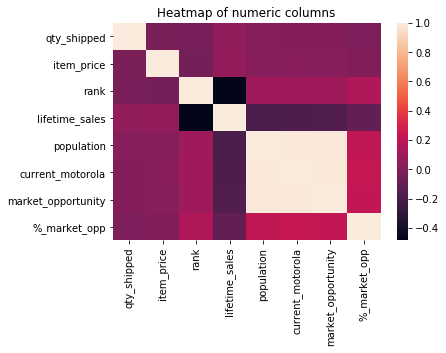

In [125]:
# Check I didn't miss any highly correlated features
display(final[num_cols].corr())
sns.heatmap(final[num_cols].corr())
plt.title('Heatmap of numeric columns')
plt.savefig('../../figures/heatmap.png')

In [127]:
final.drop(['rank','population','current_motorola'], axis=1, inplace=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7890 entries, 0 to 11417
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer            7890 non-null   object        
 1   invoice_date        7890 non-null   datetime64[ns]
 2   qty_shipped         7890 non-null   float64       
 3   item                7890 non-null   object        
 4   description         7878 non-null   object        
 5   item_price          7890 non-null   float64       
 6   customer            7890 non-null   object        
 7   industry            7890 non-null   category      
 8   contact_owner       7890 non-null   category      
 9   last_purchase       7829 non-null   datetime64[ns]
 10  lifetime_sales      7890 non-null   float64       
 11  first_sale          7890 non-null   object        
 12  county              7890 non-null   object        
 13  market_opportunity  7890 non-null   float64    

C:\Users\mdurr\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [128]:
# Final note - realized last_purchase is irrelevant here because we can determine that implicitly
# using invoice dates
final.drop('last_purchase', axis=1, inplace=True)

final.to_csv('../processed/data.csv')